### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

In [3]:
tf.__version__

'2.4.1'

###### fix random seed for reproducibility

    Generally, Keras gets its source of randomness from the NumPy random number generator.
    
    In addition, TensorFlow has its own random number generator that must also be seeded by calling the set_random_seed() function immediately after the NumPy random number generator, as follows:

In [4]:
np.random.seed(123)

tf.random.set_seed(123)

#### Loading the data

In [5]:
data = pd.read_csv("/home/datasets/lab/BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [6]:
data.shape

(61589, 23)

Display the columns

In [7]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

__See the top rows of the data__

In [8]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


__Shows a quick statistic summary of your data using describe__

In [9]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


__Display data type of each variable__

In [10]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 

    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [11]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [12]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [13]:
np.size(np.unique(data.sku))

61589

In [14]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

In [15]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

### Preparing Data for Model building

In [16]:
data['went_on_backorder'] = data['went_on_backorder'].replace(to_replace=['No', 'Yes'], value=[0, 1])
data['went_on_backorder'].value_counts()

0    50296
1    11293
Name: went_on_backorder, dtype: int64

In [17]:
X, y = data.loc[:,data.columns!='went_on_backorder'], data.loc[:,'went_on_backorder']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(43112, 21)
(43112,)
(18477, 21)
(18477,)


In [19]:
X_train.dtypes

national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
dtype: object

In [20]:
cat_attr = list(X_train.select_dtypes(include=['category']).columns)
num_attr = list(X_train.select_dtypes(include=['number']).columns)

In [21]:
print(cat_attr)
print(num_attr)

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']
['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


#### Handling Numerical Columns

##### Imputation

In [22]:
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(X_train[num_attr])

X_train[num_attr] = imputer.transform(X_train[num_attr])
X_val[num_attr] = imputer.transform(X_val[num_attr])

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/share/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [23]:
X_train.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

In [24]:
X_val.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
dtype: int64

##### Standardize the data 


In [25]:
scaler = StandardScaler()
scaler.fit(X_train[num_attr])

StandardScaler()

In [26]:
scaler.mean_

array([280.39807942,   7.58475598,  31.7570746 , 180.32192893,
       333.50714418, 478.5932223 ,  48.70351642, 168.15587307,
       311.69379755, 459.47599276,  45.86509557,   1.33239005,
        -6.23209338,  -5.79506425,   1.13017257])

In [27]:
scaler.var_

array([1.65743285e+07, 3.96771734e+01, 8.41446996e+05, 3.84987183e+07,
       1.30909776e+08, 2.76547320e+08, 2.64594279e+06, 3.85766961e+07,
       1.10699939e+08, 2.26680875e+08, 1.26537112e+06, 7.44504380e+02,
       6.49465857e+02, 6.11292307e+02, 8.74380578e+02])

In [28]:
X_train_num = pd.DataFrame(scaler.transform(X_train[num_attr]), columns=num_attr)
X_val_num = pd.DataFrame(scaler.transform(X_val[num_attr]), columns=num_attr)

In [29]:
print(X_train_num.shape)
print(X_val_num.shape)

print(type(X_train_num))
print(type(X_val_num))

(43112, 15)
(18477, 15)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


#### Handling Categorical Columns
##### Imputation

In [30]:
imputer = SimpleImputer(strategy='most_frequent')

imputer = imputer.fit(X_train[cat_attr])

X_train[cat_attr] = imputer.transform(X_train[cat_attr])
X_val[cat_attr] = imputer.transform(X_val[cat_attr])

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/share/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

##### One Hot Encoding

In [31]:
ohe = OneHotEncoder(handle_unknown='error')

In [32]:
ohe.fit(X_train[cat_attr])

columns_ohe = list(ohe.get_feature_names(cat_attr))
print(columns_ohe)

X_train_cat = ohe.transform(X_train[cat_attr])
X_val_cat = ohe.transform(X_val[cat_attr])

X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=columns_ohe)
X_val_cat = pd.DataFrame(X_val_cat.todense(), columns=columns_ohe)

['potential_issue_No', 'potential_issue_Yes', 'deck_risk_No', 'deck_risk_Yes', 'oe_constraint_No', 'oe_constraint_Yes', 'ppap_risk_No', 'ppap_risk_Yes', 'stop_auto_buy_No', 'stop_auto_buy_Yes', 'rev_stop_No', 'rev_stop_Yes']


In [33]:
print(X_train_cat.shape)
print(X_val_cat.shape)

print(type(X_train_cat))
print(type(X_val_cat))

(43112, 12)
(18477, 12)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Merging of Numerical and Categorical Dataframes

In [34]:
X_train_proc = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_proc = pd.concat([X_val_num, X_val_cat], axis=1)

In [35]:
print(X_train_proc.shape)
print(y_train.shape)
print(X_val_proc.shape)
print(y_val.shape)

(43112, 27)
(43112,)
(18477, 27)
(18477,)


In [36]:
y_train

32557    0
35028    0
18       1
24527    0
54999    0
        ..
27190    0
55221    0
2605     1
35193    1
15355    0
Name: went_on_backorder, Length: 43112, dtype: int64

### Convert dataframe to numpy array to feed into Neural Networks

In [37]:
print(type(X_train_proc))
print(type(X_val_proc))

X_train_proc_arr = X_train_proc.values
X_val_proc_arr = X_val_proc.values

print(type(X_train_proc_arr))
print(type(X_val_proc_arr))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Perceptron Model

In [38]:
perceptron_model = Sequential()
perceptron_model.add(Dense(1, activation='sigmoid', input_shape=(27,)))

In [39]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[tf.keras.metrics.Recall()])

In [40]:
perceptron_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [41]:
perceptron_model_history = perceptron_model.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
539/539 [==============================] - 1s 2ms/step - loss: 0.5636 - recall: 0.1431 - val_loss: 0.4730 - val_recall: 0.0025
Epoch 2/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4683 - recall: 0.0067 - val_loss: 0.4680 - val_recall: 0.0025
Epoch 3/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4621 - recall: 0.0081 - val_loss: 0.4656 - val_recall: 0.0037
Epoch 4/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4576 - recall: 0.0077 - val_loss: 0.4649 - val_recall: 0.0050
Epoch 5/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4602 - recall: 0.0063 - val_loss: 0.4647 - val_recall: 0.0056
Epoch 6/100
539/539 [==============================] - 0s 839us/step - loss: 0.4608 - recall: 0.0097 - val_loss: 0.4645 - val_recall: 0.0056
Epoch 7/100
539/539 [==============================] - 1s 934us/step - loss: 0.4571 - recall: 0.0095 - val_loss: 0.4645 - val_recall: 0.0056
Epoch 8/100
539/539 [==

##### Plot

In [42]:
print(perceptron_model_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


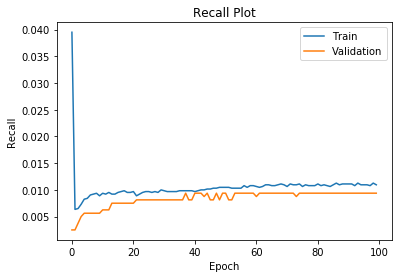

In [43]:
plt.plot(perceptron_model_history.history['recall'])
plt.plot(perceptron_model_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

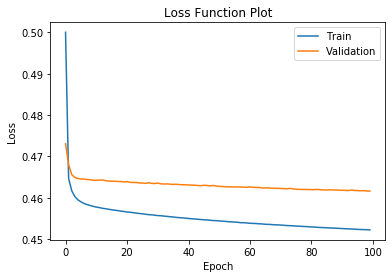

In [44]:
plt.plot(perceptron_model_history.history['loss'])
plt.plot(perceptron_model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

##### Predictions

In [45]:
val_pred = perceptron_model.predict_classes(X_val_proc_arr)
train_pred = perceptron_model.predict_classes(X_train_proc_arr)

confusion_matrix_val = confusion_matrix(y_val, val_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

/home/sujitd/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[35162    45]
 [ 7819    86]]
[[15060    29]
 [ 3343    45]]


##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [46]:
accuracy_score_train = accuracy_score(y_train, train_pred)
accuracy_score_val = accuracy_score(y_val, val_pred)

recall_score_train = recall_score(y_train, train_pred)
recall_score_val = recall_score(y_val, val_pred)

precision_score_train = precision_score(y_train, train_pred)
precision_score_val = precision_score(y_val, val_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8175913898682501
Train Recall:  0.010879190385831752
Train Precision:  0.6564885496183206
-----------------------
Val Accuracy:  0.8175028413703523
Val Recall:  0.013282172373081463
Val Precision:  0.6081081081081081


### MLP with 2 layers

    1 hidden layer with 15 neurons

In [131]:
mlp_model1 = Sequential()
# tanh, sigmoid, softmax, relu, linear,
mlp_model1.add(Dense(100, activation='relu', kernel_initializer='normal', input_shape=(27,)))
mlp_model1.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [132]:
mlp_model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 50)                1400      
_________________________________________________________________
dense_28 (Dense)             (None, 62)                3162      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 63        
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


In [133]:
mlp_model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=tf.keras.metrics.Recall(name='recall'))

In [134]:
y_train.value_counts()

0    35207
1     7905
Name: went_on_backorder, dtype: int64

In [135]:
model1_history = mlp_model1.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
539/539 [==============================] - 1s 2ms/step - loss: 0.5993 - recall: 0.0037 - val_loss: 0.4844 - val_recall: 0.0000e+00
Epoch 2/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4781 - recall: 0.0000e+00 - val_loss: 0.4757 - val_recall: 0.0000e+00
Epoch 3/100
539/539 [==============================] - 1s 2ms/step - loss: 0.4713 - recall: 0.0000e+00 - val_loss: 0.4744 - val_recall: 0.0000e+00
Epoch 4/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4671 - recall: 0.0000e+00 - val_loss: 0.4731 - val_recall: 0.0000e+00
Epoch 5/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4688 - recall: 0.0000e+00 - val_loss: 0.4718 - val_recall: 0.0000e+00
Epoch 6/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4680 - recall: 0.0000e+00 - val_loss: 0.4706 - val_recall: 0.0000e+00
Epoch 7/100
539/539 [==============================] - 1s 2ms/step - loss: 0.4640 - recall: 0.0000e+00 - val_loss: 0.4696 

##### Plot

In [51]:
print(model1_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


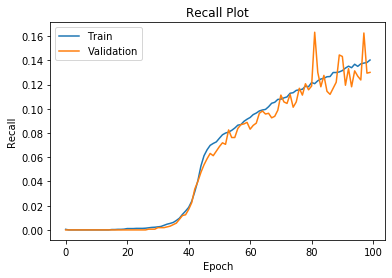

In [137]:
plt.plot(model1_history.history['recall'])
plt.plot(model1_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

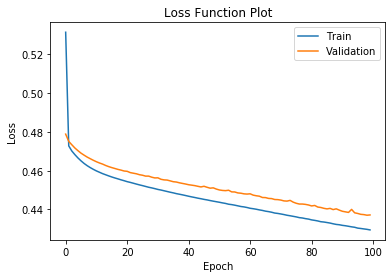

In [53]:
plt.plot(model1_history.history['loss'])
plt.plot(model1_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [138]:
train_model1_pred = mlp_model1.predict_classes(X_train_proc_arr)
val_model1_pred = mlp_model1.predict_classes(X_val_proc_arr)

/home/sujitd/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [139]:
train_model1_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [144]:
train_model1_pred = mlp_model1.predict(X_train_proc_arr)
val_model1_pred = mlp_model1.predict(X_val_proc_arr)

In [148]:
train_model1_pred = [0 if x < 0.25 else 1 for x in train_model1_pred ]  #ROC curve AUC
val_model1_pred = [0 if x < 0.25 else 1 for x in val_model1_pred]

#### Getting evaluation metrics and evaluating model performance

In [149]:
confusion_matrix_train = confusion_matrix(y_train, train_model1_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model1_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[30251  4956]
 [ 3912  3993]]
[[12976  2113]
 [ 1695  1693]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [150]:
accuracy_score_train = accuracy_score(y_train, train_model1_pred)
accuracy_score_val = accuracy_score(y_val, val_model1_pred)

recall_score_train = recall_score(y_train, train_model1_pred)
recall_score_val = recall_score(y_val, val_model1_pred)

precision_score_train = precision_score(y_train, train_model1_pred)
precision_score_val = precision_score(y_val, val_model1_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.7943032102430878
Train Recall:  0.505123339658444
Train Precision:  0.4461951055983909
-----------------------
Val Accuracy:  0.7939059371110029
Val Recall:  0.4997048406139315
Val Precision:  0.44482396216500264


### MLP with 2 layers

    1 hidden layer with 20 neurons

In [57]:
mlp_model2 = Sequential()

mlp_model2.add(Dense(20, input_shape=(27,), activation='sigmoid', kernel_initializer='normal'))
mlp_model2.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [58]:
mlp_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                560       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________


#### Callbacks - Early Stopping & ModelCheckpoint

In [59]:
import os
cwd = os.getcwd()
cwd

'/home/sujitd/7221o/day02'

In [151]:
os.path.join(cwd, 'mlp_backorders.h5')

'/home/sujitd/7221o/day02/mlp_backorders.h5'

In [152]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, min_delta=0.001)
    
model_checkpoint = ModelCheckpoint(
        os.path.join(cwd, 'mlp_backorders.h5'),
        save_weights_only=True,
        save_best_only=True,
        verbose=1)

In [153]:
callbacks = [early_stopping, model_checkpoint]

In [154]:
mlp_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=tf.keras.metrics.Recall(name='recall'))

In [155]:
model2_history = mlp_model2.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4599 - recall: 0.0043 - val_loss: 0.4677 - val_recall: 0.0025

Epoch 00001: val_loss improved from inf to 0.46774, saving model to /home/sujitd/7221o/day02/mlp_backorders.h5
Epoch 2/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4641 - recall: 0.0036 - val_loss: 0.4675 - val_recall: 0.0025

Epoch 00002: val_loss improved from 0.46774 to 0.46754, saving model to /home/sujitd/7221o/day02/mlp_backorders.h5
Epoch 3/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4616 - recall: 0.0049 - val_loss: 0.4675 - val_recall: 0.0025

Epoch 00003: val_loss improved from 0.46754 to 0.46748, saving model to /home/sujitd/7221o/day02/mlp_backorders.h5
Epoch 4/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4592 - recall: 0.0046 - val_loss: 0.4672 - val_recall: 0.0031

Epoch 00004: val_loss improved from 0.46748 to 0.46716, saving model to /home/sujitd/7221o/day02/ml

##### Plot

In [64]:
print(model2_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


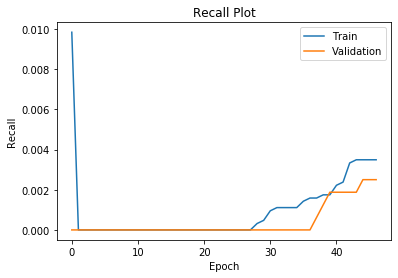

In [136]:
plt.plot(model2_history.history['recall'])
plt.plot(model2_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

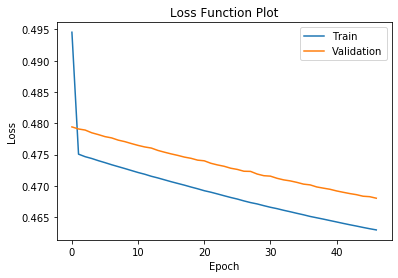

In [66]:
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [67]:
train_model2_pred = mlp_model2.predict_classes(X_train_proc_arr)
val_model2_pred = mlp_model2.predict_classes(X_val_proc_arr)

/home/sujitd/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#### Getting evaluation metrics and evaluating model performance

In [68]:
confusion_matrix_train = confusion_matrix(y_train, train_model2_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model2_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[35191    16]
 [ 7879    26]]
[[15067    22]
 [ 3374    14]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [69]:
accuracy_score_train = accuracy_score(y_train, train_model2_pred)
accuracy_score_val = accuracy_score(y_val, val_model2_pred)

recall_score_train = recall_score(y_train, train_model2_pred)
recall_score_val = recall_score(y_val, val_model2_pred)

precision_score_train = precision_score(y_train, train_model2_pred)
precision_score_val = precision_score(y_val, val_model2_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8168723325292262
Train Recall:  0.003289057558507274
Train Precision:  0.6190476190476191
-----------------------
Val Accuracy:  0.8162039292092872
Val Recall:  0.004132231404958678
Val Precision:  0.3888888888888889


### MLP with 2 layers

    1 hidden layer with 25 neurons. activation function - relu 

In [70]:
mlp_model3 = Sequential()

mlp_model3.add(Dense(25, input_shape=(27,), activation='relu', kernel_initializer='normal'))
mlp_model3.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [71]:
mlp_model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 25)                700       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26        
Total params: 726
Trainable params: 726
Non-trainable params: 0
_________________________________________________________________


In [72]:
mlp_model3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=tf.keras.metrics.Recall(name='recall'))

In [73]:
model3_history = mlp_model3.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
539/539 [==============================] - 1s 2ms/step - loss: 0.5871 - recall: 0.0060 - val_loss: 0.4762 - val_recall: 0.0000e+00

Epoch 00001: val_loss did not improve from 0.46803
Epoch 2/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4724 - recall: 0.0000e+00 - val_loss: 0.4729 - val_recall: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.46803
Epoch 3/100
539/539 [==============================] - 1s 2ms/step - loss: 0.4673 - recall: 0.0000e+00 - val_loss: 0.4711 - val_recall: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.46803
Epoch 4/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4630 - recall: 0.0000e+00 - val_loss: 0.4695 - val_recall: 6.2500e-04

Epoch 00004: val_loss did not improve from 0.46803
Epoch 5/100
539/539 [==============================] - 1s 2ms/step - loss: 0.4648 - recall: 3.0247e-04 - val_loss: 0.4682 - val_recall: 0.0012

Epoch 00005: val_loss did not improve from 0.46803
Epoch 6/100
5

##### Plot

In [74]:
print(model3_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


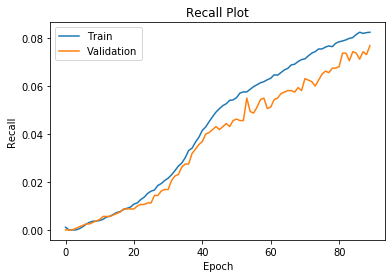

In [75]:
plt.plot(model3_history.history['recall'])
plt.plot(model3_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

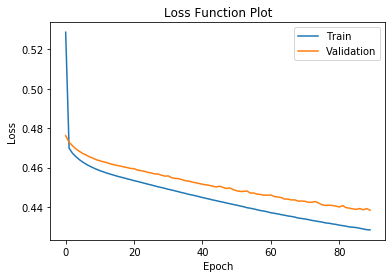

In [76]:
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [77]:
train_model3_pred = mlp_model3.predict_classes(X_train_proc_arr)
val_model3_pred = mlp_model3.predict_classes(X_val_proc_arr)

/home/sujitd/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#### Getting evaluation metrics and evaluating model performance

In [78]:
confusion_matrix_train = confusion_matrix(y_train, train_model3_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model3_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34905   302]
 [ 7246   659]]
[[14941   148]
 [ 3093   295]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [79]:
accuracy_score_train = accuracy_score(y_train, train_model3_pred)
accuracy_score_val = accuracy_score(y_val, val_model3_pred)

recall_score_train = recall_score(y_train, train_model3_pred)
recall_score_val = recall_score(y_val, val_model3_pred)

precision_score_train = precision_score(y_train, train_model3_pred)
precision_score_val = precision_score(y_val, val_model3_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8249211356466877
Train Recall:  0.08336495888678051
Train Precision:  0.6857440166493236
-----------------------
Val Accuracy:  0.8245927369161661
Val Recall:  0.0870720188902007
Val Precision:  0.6659142212189616


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 15 neurons

In [175]:
mlp_model4 = Sequential()

mlp_model4.add(Dense(25, input_shape=(27,), activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(15, activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [176]:
mlp_model4.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 25)                700       
_________________________________________________________________
dense_37 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 16        
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [177]:
mlp_model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=tf.keras.metrics.Recall(name='recall'))

In [178]:
model4_history = mlp_model4.fit(X_train_proc_arr, y_train, epochs=150, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/150
539/539 [==============================] - 1s 2ms/step - loss: 0.5207 - recall: 0.0153 - val_loss: 0.4574 - val_recall: 0.0325
Epoch 2/150
539/539 [==============================] - 1s 1ms/step - loss: 0.4504 - recall: 0.0461 - val_loss: 0.4376 - val_recall: 0.0763
Epoch 3/150
539/539 [==============================] - 1s 1ms/step - loss: 0.4300 - recall: 0.0872 - val_loss: 0.4190 - val_recall: 0.1025
Epoch 4/150
539/539 [==============================] - 1s 1ms/step - loss: 0.4116 - recall: 0.1110 - val_loss: 0.4093 - val_recall: 0.1206
Epoch 5/150
539/539 [==============================] - 1s 1ms/step - loss: 0.4021 - recall: 0.1316 - val_loss: 0.3974 - val_recall: 0.1513
Epoch 6/150
539/539 [==============================] - 1s 1ms/step - loss: 0.3960 - recall: 0.1529 - val_loss: 0.3921 - val_recall: 0.1600
Epoch 7/150
539/539 [==============================] - 1s 1ms/step - loss: 0.3843 - recall: 0.1680 - val_loss: 0.3967 - val_recall: 0.1406
Epoch 8/150
539/539 [======

##### Plot

In [160]:
print(model4_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


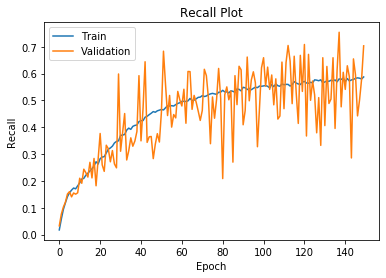

In [179]:
plt.plot(model4_history.history['recall'])
plt.plot(model4_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

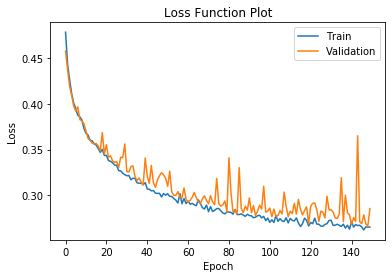

In [180]:
plt.plot(model4_history.history['loss'])
plt.plot(model4_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [181]:
train_model4_pred = mlp_model4.predict_classes(X_train_proc_arr)
val_model4_pred = mlp_model4.predict_classes(X_val_proc_arr)

/home/sujitd/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#### Getting evaluation metrics and evaluating model performance

In [182]:
confusion_matrix_train = confusion_matrix(y_train, train_model4_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model4_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[33085  2122]
 [ 2285  5620]]
[[14179   910]
 [ 1020  2368]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [183]:
accuracy_score_train = accuracy_score(y_train, train_model4_pred)
accuracy_score_val = accuracy_score(y_val, val_model4_pred)

recall_score_train = recall_score(y_train, train_model4_pred)
recall_score_val = recall_score(y_val, val_model4_pred)

precision_score_train = precision_score(y_train, train_model4_pred)
precision_score_val = precision_score(y_val, val_model4_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8977778808684357
Train Recall:  0.7109424414927261
Train Precision:  0.7259106174115215
-----------------------
Val Accuracy:  0.8955458137143476
Val Recall:  0.6989374262101535
Val Precision:  0.7223917022574741


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons

In [90]:
mlp_model5 = Sequential()

mlp_model5.add(Dense(25, input_shape=(27,), activation='relu', kernel_initializer='normal'))
mlp_model5.add(Dense(20, activation='relu', kernel_initializer='normal'))
mlp_model5.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [91]:
mlp_model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 25)                700       
_________________________________________________________________
dense_11 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [92]:
mlp_model5.compile(loss='binary_crossentropy', optimizer='sgd', metrics=tf.keras.metrics.Recall(name='recall'))

In [93]:
model5_history = mlp_model5.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
539/539 [==============================] - 1s 2ms/step - loss: 0.6064 - recall: 0.0037 - val_loss: 0.4970 - val_recall: 0.0000e+00

Epoch 00001: val_loss did not improve from 0.41386
Epoch 2/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4881 - recall: 0.0000e+00 - val_loss: 0.4808 - val_recall: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.41386
Epoch 3/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4762 - recall: 0.0000e+00 - val_loss: 0.4793 - val_recall: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.41386
Epoch 4/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4725 - recall: 0.0000e+00 - val_loss: 0.4790 - val_recall: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.41386
Epoch 5/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4752 - recall: 0.0000e+00 - val_loss: 0.4787 - val_recall: 0.0000e+00

Epoch 00005: val_loss did not improve from 0.41386
Epoch 6/1

##### Plot

In [94]:
print(model5_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


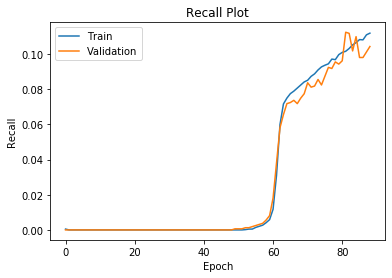

In [95]:
plt.plot(model5_history.history['recall'])
plt.plot(model5_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

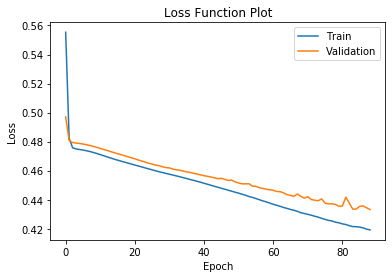

In [96]:
plt.plot(model5_history.history['loss'])
plt.plot(model5_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [97]:
train_model5_pred = mlp_model5.predict_classes(X_train_proc_arr)
val_model5_pred = mlp_model5.predict_classes(X_val_proc_arr)

/home/sujitd/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#### Getting evaluation metrics and evaluating model performance

In [98]:
confusion_matrix_train = confusion_matrix(y_train, train_model5_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model5_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34784   423]
 [ 7047   858]]
[[14878   211]
 [ 3002   386]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [99]:
accuracy_score_train = accuracy_score(y_train, train_model5_pred)
accuracy_score_val = accuracy_score(y_val, val_model5_pred)

recall_score_train = recall_score(y_train, train_model5_pred)
recall_score_val = recall_score(y_val, val_model5_pred)

precision_score_train = precision_score(y_train, train_model5_pred)
precision_score_val = precision_score(y_val, val_model5_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8267303766932641
Train Recall:  0.10853889943074004
Train Precision:  0.6697892271662763
-----------------------
Val Accuracy:  0.8261081344374087
Val Recall:  0.11393152302243212
Val Precision:  0.6465661641541038


### MLP with 4 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons

In [100]:
mlp_model6 = Sequential()

mlp_model6.add(Dense(256, input_shape=(27,), activation='relu', kernel_initializer='normal'))
mlp_model6.add(Dense(64, activation='relu'))
mlp_model6.add(Dense(8, activation='relu'))
mlp_model6.add(Dense(1, activation='sigmoid'))

In [101]:
mlp_model6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               7168      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 24,145
Trainable params: 24,145
Non-trainable params: 0
_________________________________________________________________


In [102]:
mlp_model6.compile(loss='binary_crossentropy', optimizer='sgd', metrics=tf.keras.metrics.Recall(name='recall'))

In [103]:
early_stopping = EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1)#min_delta=0.001
    
model_checkpoint = ModelCheckpoint(
        os.path.join(cwd, 'mlp_backorders.h5'),
        monitor='val_recall',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)

In [104]:
callbacks1 = [early_stopping, model_checkpoint]

In [105]:
model6_history = mlp_model6.fit(X_train_proc_arr, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks1)

Epoch 1/100
539/539 [==============================] - 2s 2ms/step - loss: 0.6021 - recall: 0.0923 - val_loss: 0.4745 - val_recall: 0.0019

Epoch 00001: val_recall improved from -inf to 0.00187, saving model to /home/sujitd/7221o/day02/mlp_backorders.h5
Epoch 2/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4695 - recall: 0.0027 - val_loss: 0.4701 - val_recall: 0.0025

Epoch 00002: val_recall improved from 0.00187 to 0.00250, saving model to /home/sujitd/7221o/day02/mlp_backorders.h5
Epoch 3/100
539/539 [==============================] - 1s 2ms/step - loss: 0.4630 - recall: 0.0049 - val_loss: 0.4672 - val_recall: 0.0025

Epoch 00003: val_recall did not improve from 0.00250
Epoch 4/100
539/539 [==============================] - 1s 1ms/step - loss: 0.4581 - recall: 0.0054 - val_loss: 0.4649 - val_recall: 0.0031

Epoch 00004: val_recall improved from 0.00250 to 0.00313, saving model to /home/sujitd/7221o/day02/mlp_backorders.h5
Epoch 5/100
539/539 [==================

##### Plot

In [106]:
print(model6_history.history.keys())

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


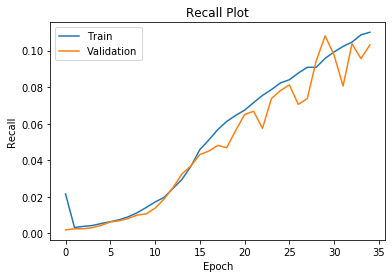

In [107]:
plt.plot(model6_history.history['recall'])
plt.plot(model6_history.history['val_recall'])
plt.title('Recall Plot')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

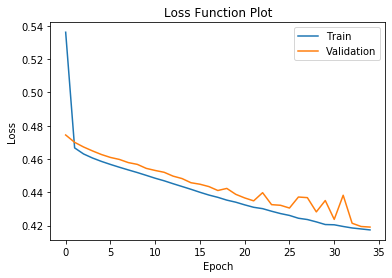

In [108]:
plt.plot(model6_history.history['loss'])
plt.plot(model6_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [109]:
train_model6_pred = mlp_model6.predict_classes(X_train_proc_arr)
val_model6_pred = mlp_model6.predict_classes(X_val_proc_arr)

/home/sujitd/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


#### Getting evaluation metrics and evaluating model performance

In [110]:
confusion_matrix_train = confusion_matrix(y_train, train_model6_pred)
confusion_matrix_val = confusion_matrix(y_val, val_model6_pred)

print(confusion_matrix_train)
print(confusion_matrix_val)

[[34820   387]
 [ 7044   861]]
[[14910   179]
 [ 3006   382]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [111]:
accuracy_score_train = accuracy_score(y_train, train_model6_pred)
accuracy_score_val = accuracy_score(y_val, val_model6_pred)

recall_score_train = recall_score(y_train, train_model6_pred)
recall_score_val = recall_score(y_val, val_model6_pred)

precision_score_train = precision_score(y_train, train_model6_pred)
precision_score_val = precision_score(y_val, val_model6_pred)


print("Train Accuracy: ",accuracy_score_train)
print("Train Recall: ",recall_score_train)
print("Train Precision: ",precision_score_train)

print("-----------------------")

print("Val Accuracy: ",accuracy_score_val)
print("Val Recall: ",recall_score_val)
print("Val Precision: ",precision_score_val)

Train Accuracy:  0.8276349972165522
Train Recall:  0.10891840607210626
Train Precision:  0.6899038461538461
-----------------------
Val Accuracy:  0.8276235319586513
Val Recall:  0.1127508854781582
Val Precision:  0.6809269162210339


Observation:

    Model 6 performs better with 256, 64 and 8 neurons
    

### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/